In [1]:
import cv2
import numpy as np
from imp_func import *
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

In [2]:
#from skimage import io
#import jsonpickle
#from flask import Flask, request, Response

In [3]:
image = cv2.imread(r"C:\Users\YASH\Desktop\CRM Project\Model\Train\train_64.jpg", cv2.IMREAD_UNCHANGED)

In [4]:
display(image)

AttributeError: 'NoneType' object has no attribute 'shape'

In [5]:
image.shape

(1280, 540, 3)

In [6]:
def deskew_image(image):
    grayscale = rgb2gray(image)
    angle = determine_skew(grayscale)
    rotated = rotate(image, angle, resize=True) * 255
    return rotated.astype(np.uint8)

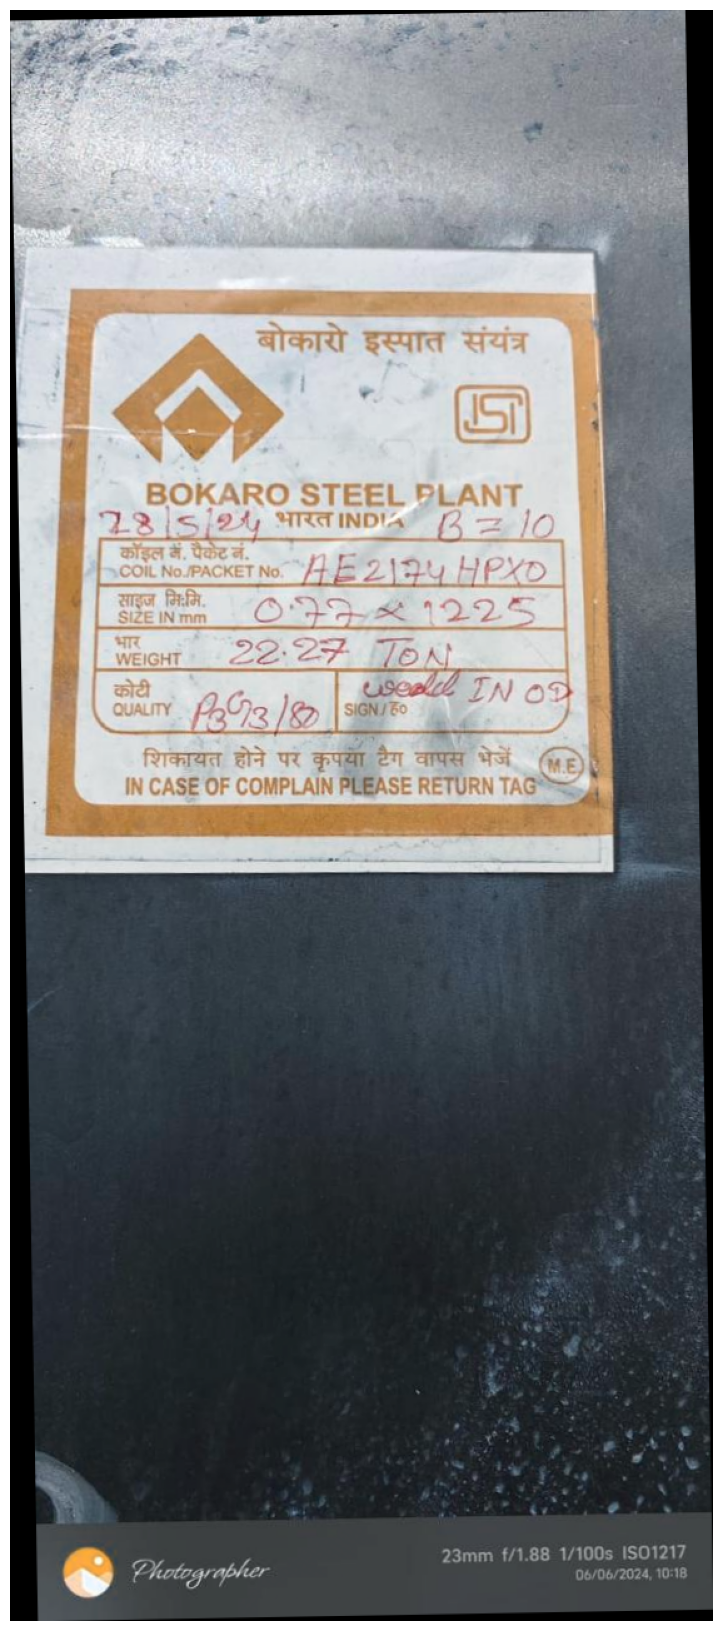

In [7]:
display(deskew_image(image))

In [8]:
def detect_and_crop_rectangular_page(image):
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            cv2.drawContours(original, [approx], -1, (0, 255, 0), 3)
            x, y, w, h = cv2.boundingRect(approx)
            cropped_image = image[y:y+h, x:x+w]
            display(original)
            display(cropped_image)
            return cropped_image
    print("No rectangular page detected.")
    return None

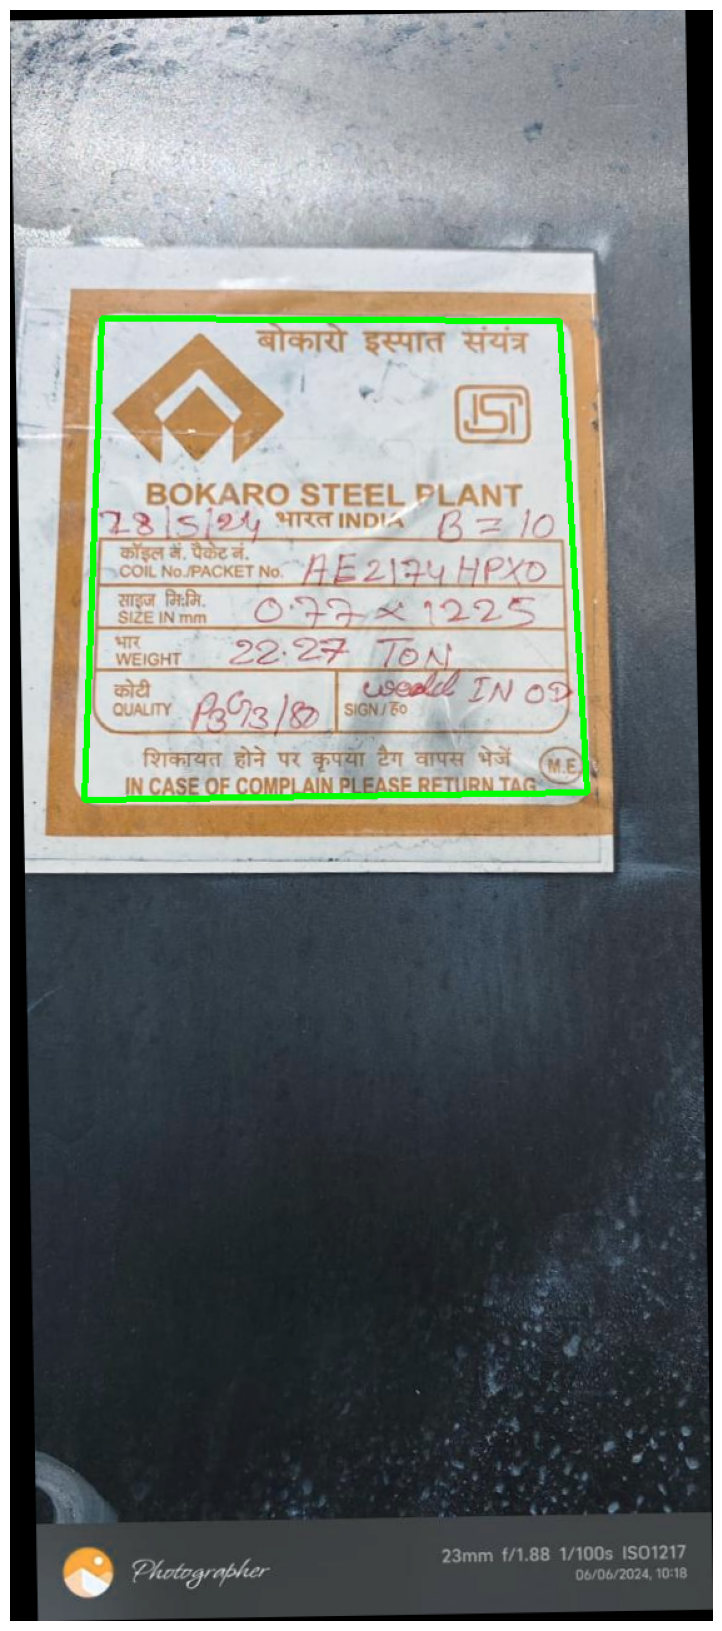

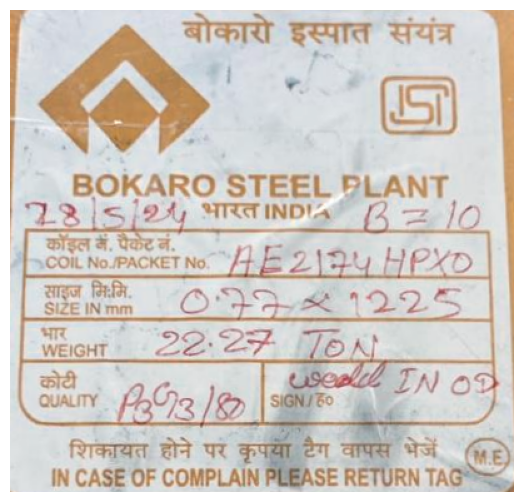

In [9]:
crop1 = detect_and_crop_rectangular_page(deskew_image(image))

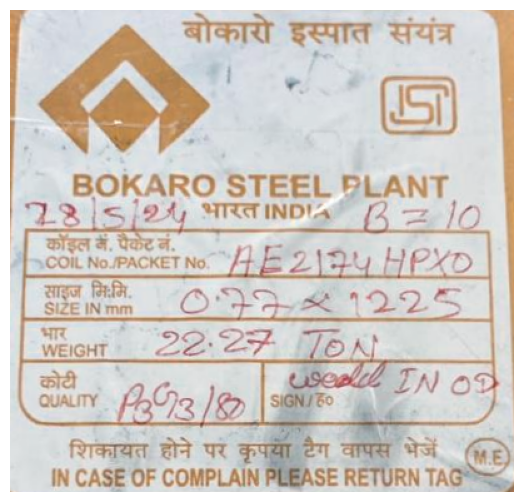

In [131]:
display(crop1)

In [10]:
crop1.shape

(386, 403, 3)

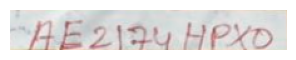

In [11]:
packet_no_crop = crop1[180:212, 160:381]
display(packet_no_crop)

In [12]:
packet_no_crop.shape

(32, 221, 3)

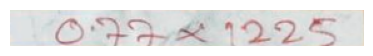

In [13]:
size_crop = crop1[216:245, 100:383]
display(size_crop)

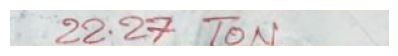

In [14]:
weight_crop = crop1[250:279, 80:383]
display(weight_crop)

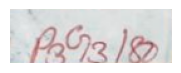

In [15]:
quality_crop = crop1[285:328, 70:199]
display(quality_crop)

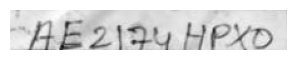

In [31]:
gray = cv2.cvtColor(packet_no_crop, cv2.COLOR_BGR2GRAY)
display(gray)

In [17]:
gray.shape

(29, 303)

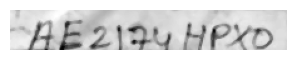

In [32]:
blur = cv2.medianBlur(gray, 3)
display(blur)

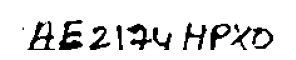

In [33]:
ret, thresh = cv2.threshold(blur, 195, 255, cv2.THRESH_BINARY)
display(thresh)

In [20]:
type(gray)

numpy.ndarray

In [21]:
gray.shape

(29, 303)

In [22]:
type(thresh)

numpy.ndarray

In [23]:
thresh.shape

(29, 303)

In [146]:
#pil_image = Image.fromarray(gray)
#binary_image = pil_image.convert("1")

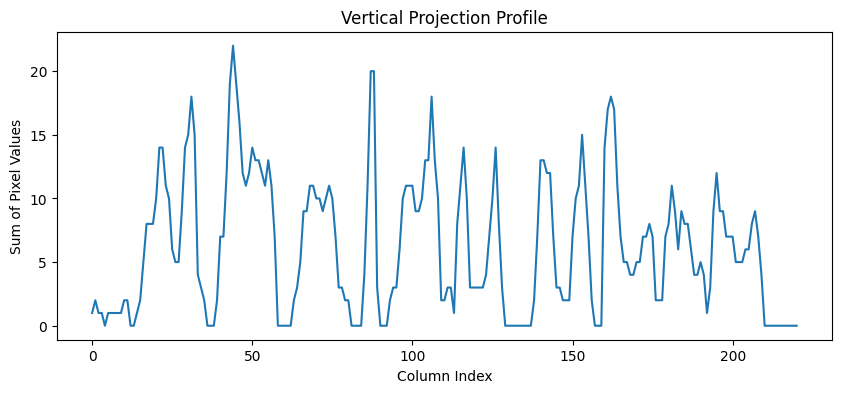

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([ 1,  2,  1,  1,  0,  1,  1,  1,  1,  1,  2,  2,  0,  0,  1,  2,  5,
         8,  8,  8, 10, 14, 14, 11, 10,  6,  5,  5,  9, 14, 15, 18, 15,  4,
         3,  2,  0,  0,  0,  2,  7,  7, 12, 19, 22, 19, 16, 12, 11, 12, 14,
        13, 13, 12, 11, 13, 11,  7,  0,  0,  0,  0,  0,  2,  3,  5,  9,  9,
        11, 11, 10, 10,  9, 10, 11, 10,  7,  3,  3,  2,  2,  0,  0,  0,  0,
         4, 11, 20, 20,  3,  0,  0,  0,  2,  3,  3,  6, 10, 11, 11, 11,  9,
         9, 10, 13, 13, 18, 13, 10,  2,  2,  3,  3,  1,  8, 11, 14, 10,  3,
         3,  3,  3,  3,  4,  7, 10, 14,  8,  3,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  2,  7, 13, 13, 12,

In [34]:
threshold = 195
binary_image = gray < threshold
vertical_projection = np.sum(binary_image, axis=0)
plt.figure(figsize=(10, 4))
plt.plot(vertical_projection)
plt.title('Vertical Projection Profile')
plt.xlabel('Column Index')
plt.ylabel('Sum of Pixel Values')
plt.show()
binary_image, vertical_projection

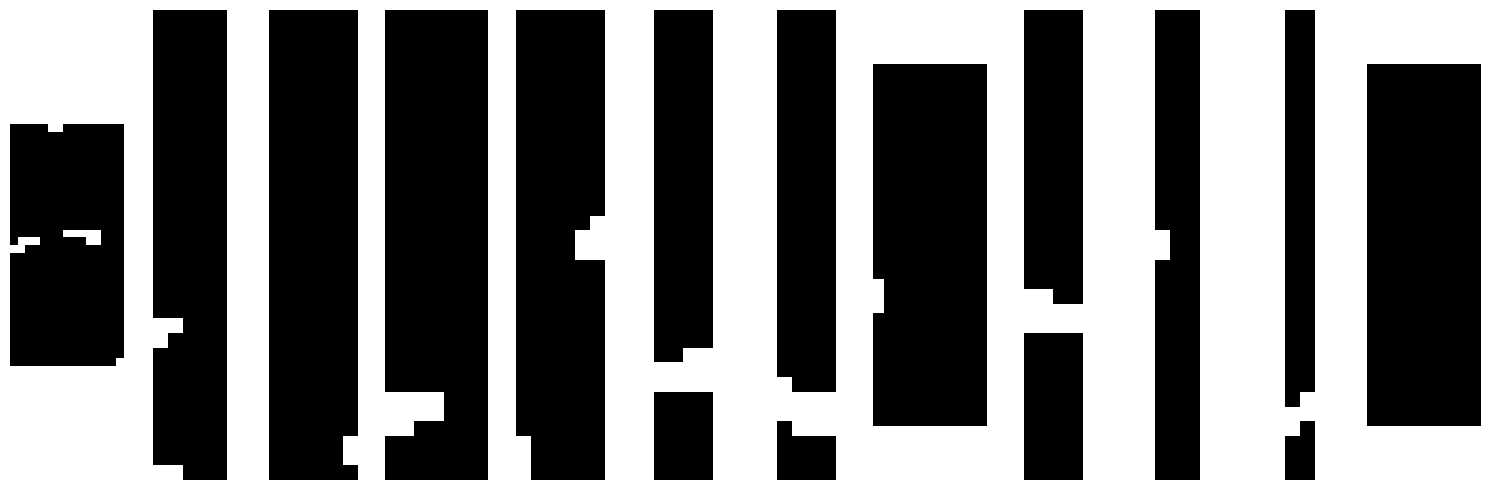

[(0, 15),
 (34, 39),
 (58, 64),
 (77, 84),
 (89, 95),
 (109, 113),
 (118, 122),
 (128, 138),
 (145, 149),
 (156, 159),
 (176, 178),
 (210, 220)]

In [35]:
threshold = 3
boundaries = np.where(vertical_projection <= threshold)[0]
segments = []
start = 0
for i in range(1, len(boundaries)):
    if boundaries[i] - boundaries[i-1] > 1:
        end = boundaries[i-1]
        if end - start > 1:
            segments.append((start, end))
        start = boundaries[i]
if boundaries[-1] - start > 1:
    segments.append((start, boundaries[-1]))
fig, axes = plt.subplots(1, len(segments), figsize=(15, 5))
for ax, (start, end) in zip(axes, segments):
    ax.imshow(binary_image[:, start:end], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

segments

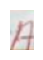

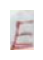

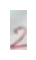

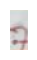

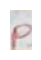

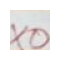

In [37]:
characters = []
for i in range(1,len(segments)):
    temp = packet_no_crop[:,segments[i-1][1]:segments[i][0]]
    display(temp)
    characters.append(temp)

In [38]:
model = tf.keras.models.load_model('IndividualCharacterModel.h5')

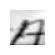

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
A


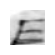

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
E


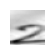

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2


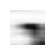

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
V


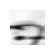

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
7


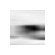

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Z


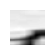

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1


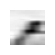

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1


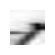

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1


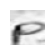

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
P


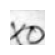

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
X
Final Text: AE2V7Z111PX


In [39]:
text = ""
character_map = {
    0: '0',  1: '1',  2: '2',  3: '3',  4: '4',  5: '5',  6: '6',  7: '7',  8: '8',  9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'c', 39: 'd', 40: 'e', 41: 'f', 42: 'g', 43: 'h', 44: 'i', 45: 'j',
    46: 'k', 47: 'l', 48: 'm', 49: 'n', 50: 'o', 51: 'p', 52: 'q', 53: 'r', 54: 's', 55: 't',
    56: 'u', 57: 'v', 58: 'w', 59: 'x', 60: 'y', 61: 'z'
}

i = 0
for c in characters:
    t = 200
    g = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
    g = cv2.resize(g, (28,28))
    display(g)
    g = g/255.0
    g = np.expand_dims(g, axis=-1)
    g = np.expand_dims(g, axis=0)
    predictions = model.predict(g)
    predicted_indices = np.argmax(predictions, axis=1)
    predicted_text = ''
    for idx in predicted_indices:
        predicted_text += character_map[idx]
    print(predicted_text)
    text+=predicted_text
    i+=1
print("Final Text:", text)

In [30]:
d = {'Packet No.': 'AE2V7Z111PX', 'Size': 'O77xi225', 'Weight': '22i2TZ1'}
print(d)

{'Packet No.': 'AE2V7Z111PX', 'Size': 'O77xi225', 'Weight': '22i2TZ1'}
